(50000, 3586)


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [alpha]
>Metropolis: [beta]
Sampling 2 chains: 100%|██████████| 3000/3000 [50:07<00:00,  1.55s/draws]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


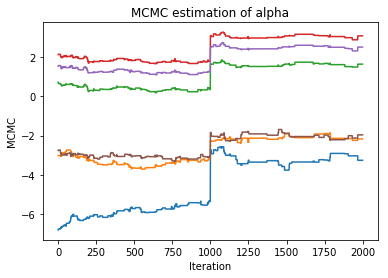

100%|██████████| 2000/2000 [21:13<00:00,  1.55it/s]

测试集准确率：0.837000
Complete time: 4485.400027 s


In [2]:
#贝叶斯多分类逻辑回归实验一：诊断参数收敛
import theano
import pymc3 as pm
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score
import theano.tensor as tt
from sklearn import datasets
import time
import numpy as np
import matplotlib.pyplot as plt
starttime = time.time()
#1.加载训练文件
data = pd.read_csv("/data/fjsdata/mathVR3W.csv",sep='|',low_memory=False)#,iterator =True)
#data = data.get_chunk(100)
print (data.shape)
#2.构造训练集和测试集
X_train, X_test, Y_train, Y_test = train_test_split(data.drop(columns=['quid','qdiff']), data['qdiff'], test_size=.2)#8成训练，2成测试
#3.构建softmax regression model
X_input = theano.shared(X_train.values)#转numpy array
Y_output = theano.shared(Y_train.values)#转numpy array
with pm.Model() as EDP_model:
    beta = pm.Normal('beta', mu=0, sd=3, shape=(3584,6))
    alpha = pm.Normal('alpha', mu=0, sd=6, shape=6)
    mu = tt.dot(X_input,beta) + alpha
    p = pm.Deterministic('p', tt.nnet.softmax(mu))
    Y_obs = pm.Categorical('Y_obs', p=p, observed=Y_output)
#4.nuts采样
with EDP_model:
    #start=pm.find_MAP()  # 参数初猜
    step = pm.Metropolis()#多分类采样#step = pm.NUTS()连续采样
    #trace = pm.sample(1000,start=start,step=step,chains=2,cores=2)
    trace = pm.sample(1000,step=step,chains=2,cores=2)

#pm.summary(trace)
plt.plot(trace['alpha'])#诊断后验参数
plt.xlabel('Iteration')
plt.ylabel('MCMC')
plt.title('MCMC estimation of alpha')
plt.show()
    
X_input.set_value(X_test.values)##诊断后验参数测试集
Y_output.set_value(Y_test.values)#测试集
with EDP_model:
    ppc = pm.sample_posterior_predictive(trace)#后验预测 
    Y_pred = ppc['Y_obs'].mean(axis=0)
    
print ('测试集准确率：%f'% accuracy_score(Y_test,Y_pred.round()))
endtime = time.time()
print ("Complete time: %f s" % (endtime - starttime))

(50000, 3586)


logp = -33,930, ||grad|| = 0.48625: 100%|██████████| 275/275 [06:33<00:00,  1.43s/it]     
Population sampling (6 chains)
DEMetropolis: [alpha, beta]
Chains are not parallelized. You can enable this by passing pm.sample(parallelize=True).
100%|██████████| 1500/1500 [4:12:17<00:00, 10.12s/it]  
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


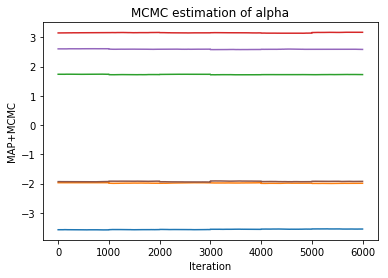

100%|██████████| 6000/6000 [1:17:18<00:00,  1.45it/s]


测试集准确率：0.834200
Complete time: 20458.189444 s


In [7]:
#贝叶斯多分类逻辑回归实验一：采样方法试验
import theano
import pymc3 as pm
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score
import theano.tensor as tt
from sklearn import datasets
import time
import numpy as np
import matplotlib.pyplot as plt
starttime = time.time()
#1.加载训练文件
data = pd.read_csv("/data/fjsdata/mathVR3W.csv",sep='|',low_memory=False)#,iterator =True)
#data = data.get_chunk(100)
print (data.shape)
#2.构造训练集和测试集
X_train, X_test, Y_train, Y_test = train_test_split(data.drop(columns=['quid','qdiff']), data['qdiff'], test_size=.2)#8成训练，2成测试
#3.构建softmax regression model
X_input = theano.shared(X_train.values)#转numpy array
Y_output = theano.shared(Y_train.values)#转numpy array
with pm.Model() as EDP_model:
    beta = pm.Normal('beta', mu=0, sd=1, shape=(3584,6))
    alpha = pm.Normal('alpha', mu=0, sd=5, shape=6)
    mu = tt.dot(X_input,beta) + alpha
    p = pm.Deterministic('p', tt.nnet.softmax(mu))
    Y_obs = pm.Categorical('Y_obs', p=p, observed=Y_output)
#4.nuts采样
with EDP_model:
    start=pm.find_MAP()  # 参数初猜
    #step = pm.Metropolis()#多分类采样#step = pm.NUTS()连续采样
    #step = pm.NUTS()
    step = pm.DEMetropolis()
    trace = pm.sample(1000,start=start,step=step,chains=6,cores=6)

#pm.summary(trace)
plt.plot(trace['alpha'])#诊断后验参数
plt.xlabel('Iteration')
plt.ylabel('MAP+MCMC')
plt.title('MCMC estimation of alpha')
plt.show()
    
X_input.set_value(X_test.values)##诊断后验参数测试集
Y_output.set_value(Y_test.values)#测试集
with EDP_model:
    ppc = pm.sample_posterior_predictive(trace)#后验预测 
    Y_pred = ppc['Y_obs'].mean(axis=0)
    
print ('测试集准确率：%f'% accuracy_score(Y_test,Y_pred.round()))
endtime = time.time()
print ("Complete time: %f s" % (endtime - starttime))

(50000, 3586)


Average Loss = 27,503: 100%|██████████| 10000/10000 [2:49:46<00:00,  1.15s/it]  
Finished [100%]: Average Loss = 27,377


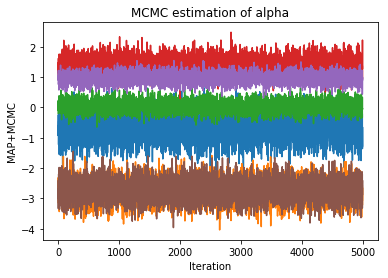

100%|██████████| 5000/5000 [1:05:28<00:00,  1.30it/s]


测试集准确率：0.845100
Complete time: 17322.829395 s


In [9]:
#贝叶斯多分类逻辑回归实验一：变分推断+采样次数
import theano
import pymc3 as pm
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score
import theano.tensor as tt
from sklearn import datasets
import time
import numpy as np
import matplotlib.pyplot as plt
starttime = time.time()
#1.加载训练文件
data = pd.read_csv("/data/fjsdata/mathVR3W.csv",sep='|',low_memory=False)#,iterator =True)
#data = data.get_chunk(100)
print (data.shape)
#2.构造训练集和测试集
X_train, X_test, Y_train, Y_test = train_test_split(data.drop(columns=['quid','qdiff']), data['qdiff'], test_size=.2)#8成训练，2成测试
#3.构建softmax regression model
X_input = theano.shared(X_train.values)#转numpy array
Y_output = theano.shared(Y_train.values)#转numpy array
with pm.Model() as EDP_model:
    beta = pm.Normal('beta', mu=0, sd=1, shape=(3584,6))
    alpha = pm.Normal('alpha', mu=0, sd=5, shape=6)
    mu = tt.dot(X_input,beta) + alpha
    p = pm.Deterministic('p', tt.nnet.softmax(mu))
    Y_obs = pm.Categorical('Y_obs', p=p, observed=Y_output)
#4.nuts采样
with EDP_model:
    inference = pm.ADVI()
    approx = pm.fit(n=10000, method=inference)
    trace = approx.sample(draws=5000)
#pm.summary(trace)
plt.plot(trace['alpha'])#诊断后验参数
plt.xlabel('Iteration')
plt.ylabel('MAP+MCMC')
plt.title('MCMC estimation of alpha')
plt.show()
    
X_input.set_value(X_test.values)##诊断后验参数测试集
Y_output.set_value(Y_test.values)#测试集
with EDP_model:
    ppc = pm.sample_posterior_predictive(trace)#后验预测 
    Y_pred = ppc['Y_obs'].mean(axis=0)
    
print ('测试集准确率：%f'% accuracy_score(Y_test,Y_pred.round()))
endtime = time.time()
print ("Complete time: %f s" % (endtime - starttime))

(50000, 3586)


Average Loss = 26,262: 100%|██████████| 30000/30000 [8:06:55<00:00,  1.07it/s]  
Finished [100%]: Average Loss = 26,461


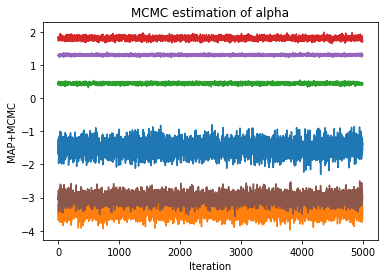

100%|██████████| 5000/5000 [59:31<00:00,  1.39it/s]  


测试集准确率：0.846500
Complete time: 35766.831760 s


In [12]:
#贝叶斯多分类逻辑回归实验一：变分推断+采样次数
import theano
import pymc3 as pm
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score
import theano.tensor as tt
from sklearn import datasets
import time
import numpy as np
import matplotlib.pyplot as plt
starttime = time.time()
#1.加载训练文件
data = pd.read_csv("/data/fjsdata/mathVR3W.csv",sep='|',low_memory=False)#,iterator =True)
#data = data.get_chunk(100)
print (data.shape)
#2.构造训练集和测试集
X_train, X_test, Y_train, Y_test = train_test_split(data.drop(columns=['quid','qdiff']), data['qdiff'], test_size=.2)#8成训练，2成测试
#3.构建softmax regression model
X_input = theano.shared(X_train.values)#转numpy array
Y_output = theano.shared(Y_train.values)#转numpy array
with pm.Model() as EDP_model:
    beta = pm.Normal('beta', mu=0, sd=1, shape=(3584,6))
    alpha = pm.Normal('alpha', mu=0, sd=5, shape=6)
    mu = tt.dot(X_input,beta) + alpha
    p = pm.Deterministic('p', tt.nnet.softmax(mu))
    Y_obs = pm.Categorical('Y_obs', p=p, observed=Y_output)
#4.nuts采样
with EDP_model:
    inference = pm.ADVI()
    approx = pm.fit(n=30000, method=inference)
    trace = approx.sample(draws=5000)
#pm.summary(trace['alpha'])
plt.plot(trace['alpha'])#诊断后验参数
plt.xlabel('Iteration')
plt.ylabel('MAP+MCMC')
plt.title('MCMC estimation of alpha')
plt.show()
    
X_input.set_value(X_test.values)##诊断后验参数测试集
Y_output.set_value(Y_test.values)#测试集
with EDP_model:
    ppc = pm.sample_posterior_predictive(trace)#后验预测 
    Y_pred = ppc['Y_obs'].mean(axis=0)
    
print ('测试集准确率：%f'% accuracy_score(Y_test,Y_pred.round()))
endtime = time.time()
print ("Complete time: %f s" % (endtime - starttime))

(50000, 3586)


Average Loss = 25,368: 100%|██████████| 10000/10000 [2:43:07<00:00,  1.01s/it]  
Finished [100%]: Average Loss = 25,770


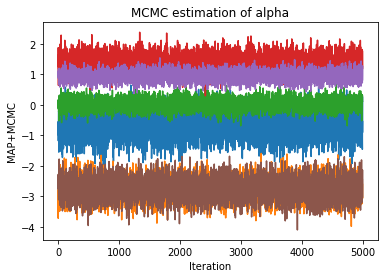

100%|██████████| 5000/5000 [1:02:09<00:00,  1.32it/s]


测试集准确率：0.837400
Complete time: 16697.641890 s


In [32]:
#贝叶斯多分类逻辑回归实验一：变分推断+后验观察
import theano
import pymc3 as pm
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score
import theano.tensor as tt
from sklearn import datasets
import time
import numpy as np
import matplotlib.pyplot as plt
starttime = time.time()
#1.加载训练文件
data = pd.read_csv("/data/fjsdata/mathVR3W.csv",sep='|',low_memory=False)#,iterator =True)
#data = data.get_chunk(100)
print (data.shape)
#2.构造训练集和测试集
X_train, X_test, Y_train, Y_test = train_test_split(data.drop(columns=['quid','qdiff']), data['qdiff'], test_size=.2)#8成训练，2成测试
#3.构建softmax regression model
X_input = theano.shared(X_train.values)#转numpy array
Y_output = theano.shared(Y_train.values)#转numpy array
with pm.Model() as EDP_model:
    beta = pm.Normal('beta', mu=0, sd=1, shape=(3584,6))
    alpha = pm.Normal('alpha', mu=0, sd=5, shape=6)
    mu = tt.dot(X_input,beta) + alpha
    p = pm.Deterministic('p', tt.nnet.softmax(mu))
    Y_obs = pm.Categorical('Y_obs', p=p, observed=Y_output)
#4.nuts采样
with EDP_model:
    inference = pm.ADVI()
    approx = pm.fit(n=10000, method=inference)
    trace = approx.sample(draws=5000)
    
#pm.traceplot(trace, varnames=['alpha']);
#pm.summary(trace, varnames=['alpha'])
plt.plot(trace['alpha'])#诊断后验参数
plt.xlabel('Iteration')
plt.ylabel('MAP+MCMC')
plt.title('MCMC estimation of alpha')
plt.show()
    
X_input.set_value(X_test.values)##诊断后验参数测试集
Y_output.set_value(Y_test.values)#测试集
with EDP_model:
    ppc = pm.sample_posterior_predictive(trace)#后验预测 
    #print (np.asarray(ppc['Y_obs']).shape)
    #print (type(ppc['Y_obs']))#<class 'numpy.ndarray'>
    #Y_pred = ppc['Y_obs'].mean(axis=0)
    Y_pred = pd.DataFrame(ppc['Y_obs']).mode(axis=0)

#print ('测试集准确率：%f'% accuracy_score(Y_test,Y_pred.round()))
print ('测试集准确率：%f'% accuracy_score(Y_test,Y_pred.values[0]))
endtime = time.time()
print ("Complete time: %f s" % (endtime - starttime))

(50000, 3586)


Average Loss = 28,187: 100%|██████████| 30000/30000 [7:48:36<00:00,  1.05it/s]  
Finished [100%]: Average Loss = 28,513


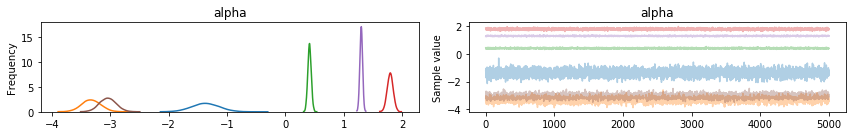

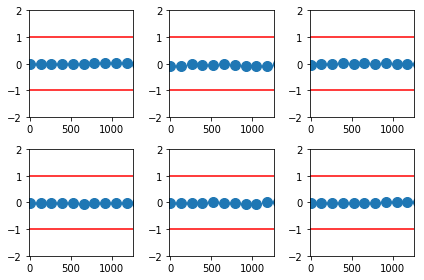

100%|██████████| 5000/5000 [54:57<00:00,  1.49it/s]  


测试集准确率：0.843900
Complete time: 34246.285268 s


In [35]:
#贝叶斯多分类逻辑回归实验一：变分推断+收敛验证
import theano
import pymc3 as pm
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score
import theano.tensor as tt
from sklearn import datasets
import time
import numpy as np
import matplotlib.pyplot as plt
starttime = time.time()
#1.加载训练文件
data = pd.read_csv("/data/fjsdata/mathVR5W.csv",sep='|',low_memory=False)#,iterator =True)
#data = data.get_chunk(100)
print (data.shape)
#2.构造训练集和测试集
X_train, X_test, Y_train, Y_test = train_test_split(data.drop(columns=['quid','qdiff']), data['qdiff'], test_size=.2)#8成训练，2成测试
#3.构建softmax regression model
X_input = theano.shared(X_train.values)#转numpy array
Y_output = theano.shared(Y_train.values)#转numpy array
with pm.Model() as EDP_model:
    beta = pm.Normal('beta', mu=0, sd=1, shape=(3584,6))
    alpha = pm.Normal('alpha', mu=0, sd=5, shape=6)
    mu = tt.dot(X_input,beta) + alpha
    p = pm.Deterministic('p', tt.nnet.softmax(mu))
    Y_obs = pm.Categorical('Y_obs', p=p, observed=Y_output)
#4.nuts采样
with EDP_model:
    inference = pm.ADVI()
    approx = pm.fit(n=30000, method=inference)
    trace = approx.sample(draws=5000)
    
    pm.traceplot(trace, varnames=['alpha'])
    pm.summary(trace, varnames=['alpha'])
    plt.show()
    score=pm.geweke(trace['alpha'], first=0.1, last=0.5, intervals=20)
    plt.title('Comparing first 10% and Slices of the Last 50% of Chain\nDifference in Mean Z score')
    for i in range(6): 
        plt.subplot(2,3,i+1)#3行2列
        plt.scatter(score[i][:,0],score[i][:,1], marker = 'o', s=100)
        plt.axhline(-1, c='r')
        plt.axhline(1, c='r')
        plt.ylim(-2,2)
        plt.xlim(0-10,.5*trace['alpha'].shape[0]/2+10)
    plt.tight_layout()
    plt.show()

X_input.set_value(X_test.values)##诊断后验参数测试集
Y_output.set_value(Y_test.values)#测试集
with EDP_model:
    ppc = pm.sample_posterior_predictive(trace)#后验预测 
    Y_pred = ppc['Y_obs'].mean(axis=0)

print ('测试集准确率：%f'% accuracy_score(Y_test,Y_pred.round()))
endtime = time.time()
print ("Complete time: %f s" % (endtime - starttime))